### Interpretability of Random Forests for all regions.

File generated 9/25/2025 (hbd)

This file works on making the plots for each region based on predictions. 

Again, update file to use modified data from separated training/testing norm. 

In [1]:
#relevant import statements
import numpy as np
import math
import pandas as pd
import xarray as xr 
import pickle 
import matplotlib.pyplot as plt


#import seaborn as sns # statistical data visualization

##just to stop the excess number of warnings 
import warnings
warnings.filterwarnings('ignore')

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from geopy.distance import great_circle
import cartopy.crs as ccrs
from matplotlib.path import Path

In [2]:
##import files to make the plots
from PredictionPlots import extrapolate
from PredictionPlots import daily_anomaly

from PredictionPlots import preprocess_ellipse
from PredictionPlots import BWcheckevent_label
from PredictionPlots import CScheckevent_label

from PredictionPlots import BWplot
from PredictionPlots import GPH_horzCS
from PredictionPlots import GPH_vertCS
from PredictionPlots import Temp_horzCS

from TempCompare import Tempcheckevent_label

In [3]:
def date_place(list1, idx):
    
    ranges = np.array([x for x in range(0,idx*10,1)])
    ranges = ranges.reshape(10,idx) 
    ranges.shape
    
    half = round(idx/2)
    #print(half)
    less = 0
    greater = 0
    
    for i in range(0,10):
        for j in range(0,idx):
            #index for the date being observed
            date_index = ranges[i,j]
            for val in list1:
                if val == date_index and i == 0:
                    if val < half:
                        less += 1
                    if val >= half:
                        greater += 1
                if val == date_index and i > 0:
                    val = val-(idx*i)
                    if val < half:
                        less += 1
                    if val >= half:
                        greater += 1

    return less, greater;

In [4]:
##set up input file 
shift = 14
idx = 135 #129 for 20, 119 for 30.

input_metrics = np.empty((62,idx,8))
input = preprocess_ellipse(input_metrics,shift,idx)
input

Load data...
Remove leap year and shift data...
Test wind shape: (62, 135)
 
Removing NaNs ...
Returning final input array.


array([[[ 2.47599697e+01,  1.75386460e+00,  8.73529587e+01, ...,
          7.41090951e+01,  8.20421534e+01,  1.38378601e-01],
        [ 2.48346329e+01,  1.90333765e+00,  8.72026282e+01, ...,
          7.45326570e+01,  1.19906140e+02,  2.00446590e-01],
        [ 2.57907333e+01,  1.94319401e+00,  8.63205371e+01, ...,
          7.82445451e+01,  1.15771286e+02,  8.97867546e-02],
        ...,
        [ 3.64532700e+01,  1.16159156e+00,  8.47183391e+01, ...,
          1.01121249e+02, -1.76261679e+02, -9.05063548e-02],
        [ 3.44312019e+01,  1.11208075e+00,  8.42274559e+01, ...,
          8.22851492e+01, -1.60331940e+02, -2.14183384e-02],
        [ 3.29570198e+01,  1.24538832e+00,  8.47493430e+01, ...,
          8.39051194e+01, -1.35024313e+02, -4.18648642e-02]],

       [[ 1.80046349e+01,  1.32903736e+00,  7.63172533e+01, ...,
          1.24954313e+02,  1.36757884e+02,  4.12963333e-01],
        [ 1.80891266e+01,  1.39829317e+00,  7.56855007e+01, ...,
          1.24873833e+02,  1.52903531e

In [5]:
#separate input file py region based on feature selection
##Europe
eur_input = np.empty((62,idx,4))
eur_metrics_list = ["Geopotential Height (m)","Size (10$^7$m)",
                    "Central Longitude ($^o$)","Zonal-Mean Wind (m/s)"]
eur_input[:,:,0] = input[:,:,6]
eur_input[:,:,1] = input[:,:,4]
eur_input[:,:,2] = input[:,:,3]
eur_input[:,:,3] = input[:,:,0]

##Canada
canada_input = np.empty((62,idx,4))
canada_metrics_list = ["Geopotential Height (m)","Zonal-Mean Wind (m/s)",
                       "PV (K*m$^2$·s$^-1$·kg$^-1$)","Central Latitude ($^o$)"]
canada_input[:,:,0] = input[:,:,6]
canada_input[:,:,1] = input[:,:,0]
canada_input[:,:,2] = input[:,:,7]
canada_input[:,:,3] = input[:,:,2]

##SEUS
seus_input = np.empty((62,idx,4))
seus_metrics_list = ["Size (10$^7$m)","Zonal-Mean Wind (m/s)",
                     "Geopotential Height (m)","PV (K*m$^2$·s$^-1$·kg$^-1$)"]
seus_input[:,:,0] = input[:,:,4]
seus_input[:,:,1] = input[:,:,0]
seus_input[:,:,2] = input[:,:,6]
seus_input[:,:,3] = input[:,:,7]

In [6]:
##open index files for models
##Europe
infile = open("./index/posXtest_eur14.p", 'rb') 
eur_pos = pickle.load(infile)
infile.close()

infile = open("./index/FposXtest_eur14.p", 'rb') 
eur_Fpos = pickle.load(infile)
infile.close()

infile = open("./index/negXtest_eur14.p", 'rb') 
eur_neg = pickle.load(infile)
infile.close()

infile = open("./index/FnegXtest_eur14.p", 'rb') 
eur_Fneg = pickle.load(infile)
infile.close()

##Canada
infile = open("./index/posXtest_can14.p", 'rb') 
can_pos = pickle.load(infile)
infile.close()

infile = open("./index/FposXtest_can14.p", 'rb') 
can_Fpos = pickle.load(infile)
infile.close()

infile = open("./index/negXtest_can14.p", 'rb') 
can_neg = pickle.load(infile)
infile.close()

infile = open("./index/FnegXtest_can14.p", 'rb') 
can_Fneg = pickle.load(infile)
infile.close()

##SEUS
infile = open("./index/posXtest_seu14.p", 'rb') 
seu_pos = pickle.load(infile)
infile.close()

infile = open("./index/FposXtest_seu14.p", 'rb') 
seu_Fpos = pickle.load(infile)
infile.close()

infile = open("./index/negXtest_seu14.p", 'rb') 
seu_neg = pickle.load(infile)
infile.close()

infile = open("./index/FnegXtest_seu14.p", 'rb') 
seu_Fneg = pickle.load(infile)
infile.close()

In [7]:
##for horizontal cross sections of GPH
infile = open("../../data/gph/1959composite_capGPH10.p","rb")
gph_input = pickle.load(infile)  ##GPH vertical cross section along longitudes
gph_input = np.delete(gph_input,[151],1)
GPH = gph_input[52:62, 19+shift:168, :, :].reshape((10, idx, 26, 180)) 
infile.close()

infile = open("../../data/gph/1959anom_capGPH10.p","rb")
gph_input = pickle.load(infile)  ##GPH vertical cross section along longitudes
gph_input = np.delete(gph_input,[151],1)
GPHA = gph_input[52:62, 19+shift:168, :, :].reshape((10, idx, 26, 180))
infile.close()

print("GPH shape: ",GPH.shape)

GPH shape:  (10, 135, 26, 180)


In [8]:
#for vertical cross sections of GPH
infile = open("../../data/gph/1959_gphforNAO.p","rb")
gph_input = pickle.load(infile)  ##GPH vertical cross section along longitudes
gph_input = np.delete(gph_input,[151],1)
vert_GPH= gph_input[52:62, 19+shift:168, :, :].reshape((10, idx, 37, 180)) 
infile.close()

print("Vertical GPH shape: ",vert_GPH.shape)

Vertical GPH shape:  (10, 135, 37, 180)


In [9]:
infile = open("../../data/NH_tempanoms_Nov90-40.p","rb",)
temp_input = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
TEMP = temp_input[52:62, shift:, :, :].reshape((10, idx, 26, 180))
infile.close()

In [10]:
lat = np.arange(90, 38, -2)
print("Len (90-40) Latitudes: ", len(lat))
lat2 = np.arange(90, 18, -2)
print("Len (90-20) Latitudes: ", len(lat2))
lon = np.arange(0, 362, 2)
print("Len longitudes: ", len(lon))
lev = np.array([1., 2., 3., 5., 7., 10., 20., 30., 50., 70., 100., 125., 150., 175., 200., 225., 250., 300., 350., 400., 
                450., 500., 550., 600., 650., 700., 750., 775., 800., 825., 850., 875., 900., 925., 950., 975., 1000.])
print("Len levels: ", len(lev))

Len (90-40) Latitudes:  26
Len (90-20) Latitudes:  36
Len longitudes:  181
Len levels:  37


## Plot!

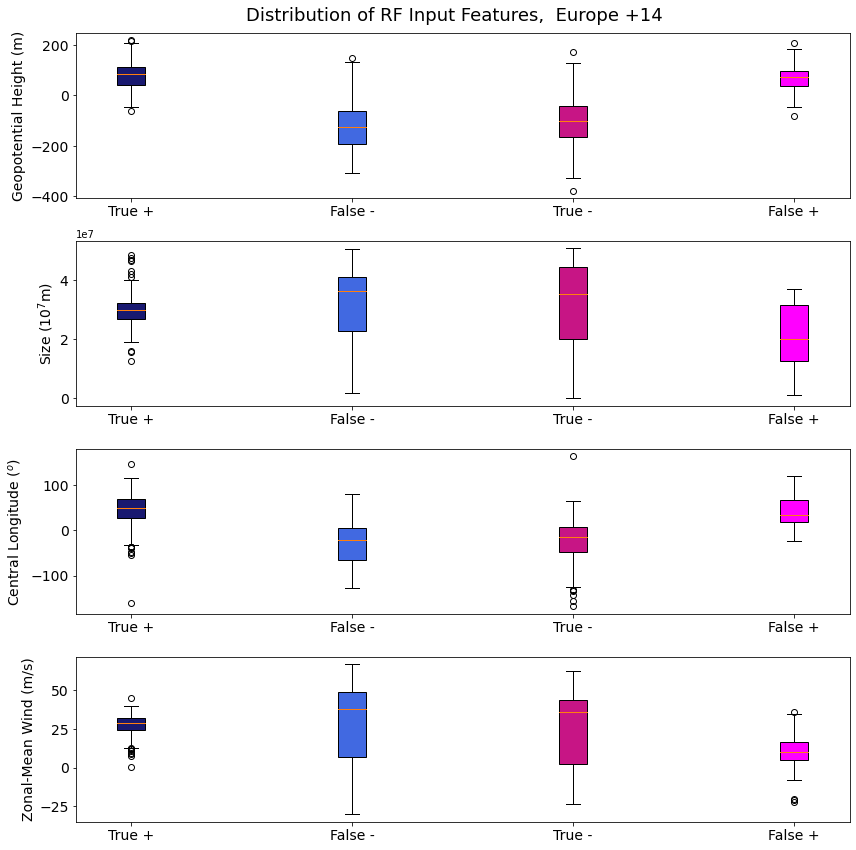

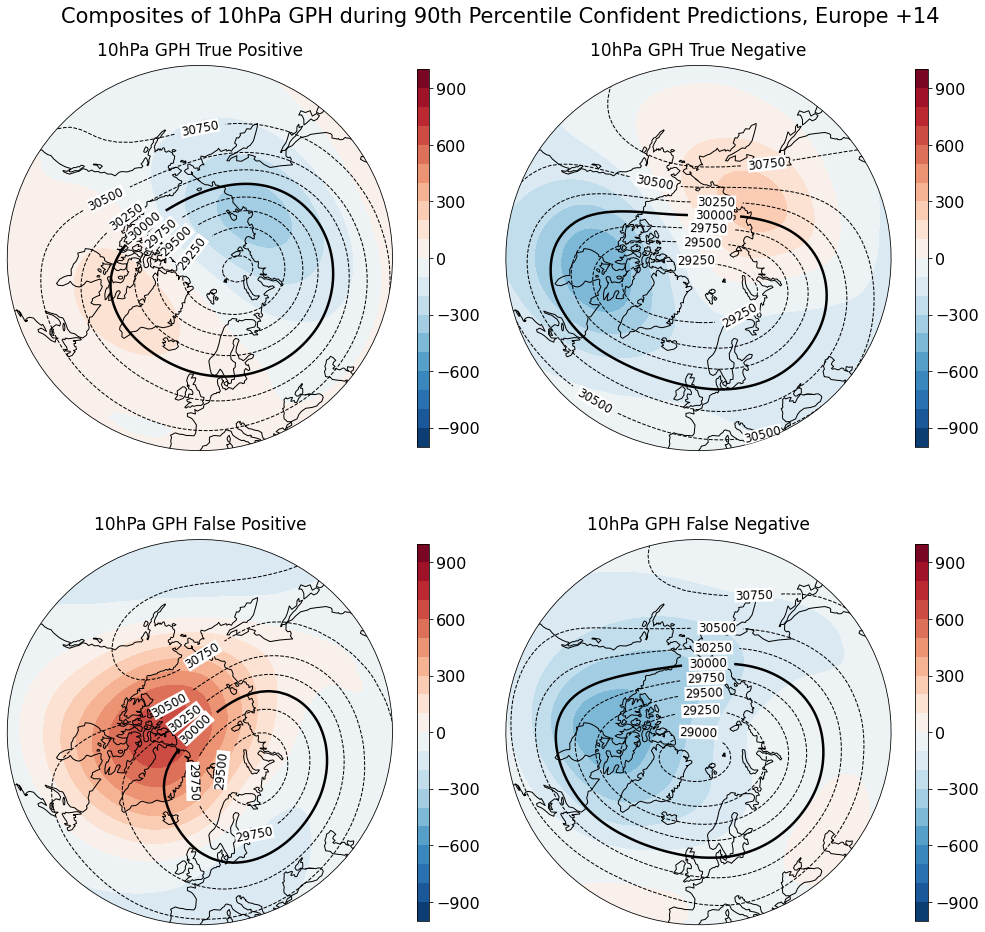

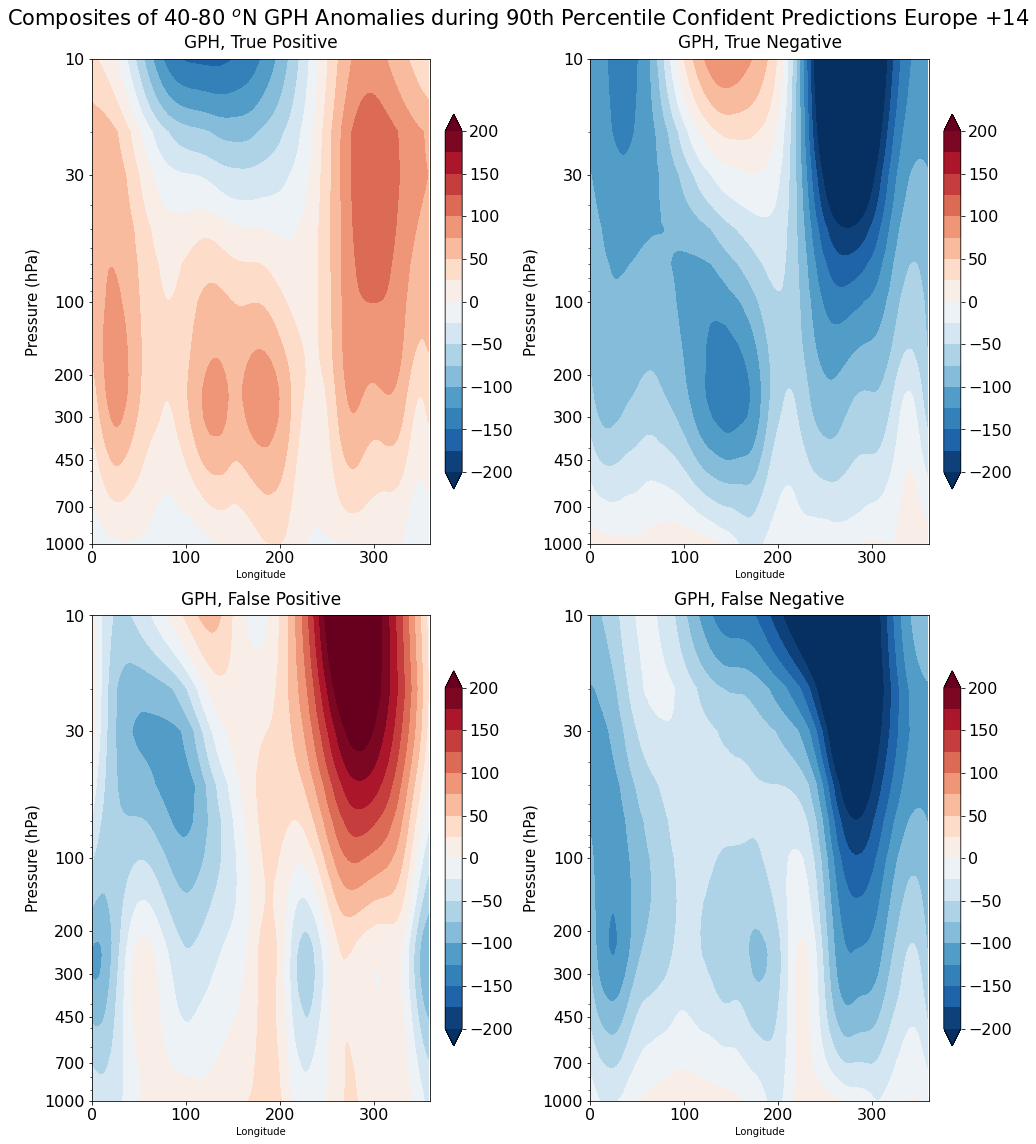

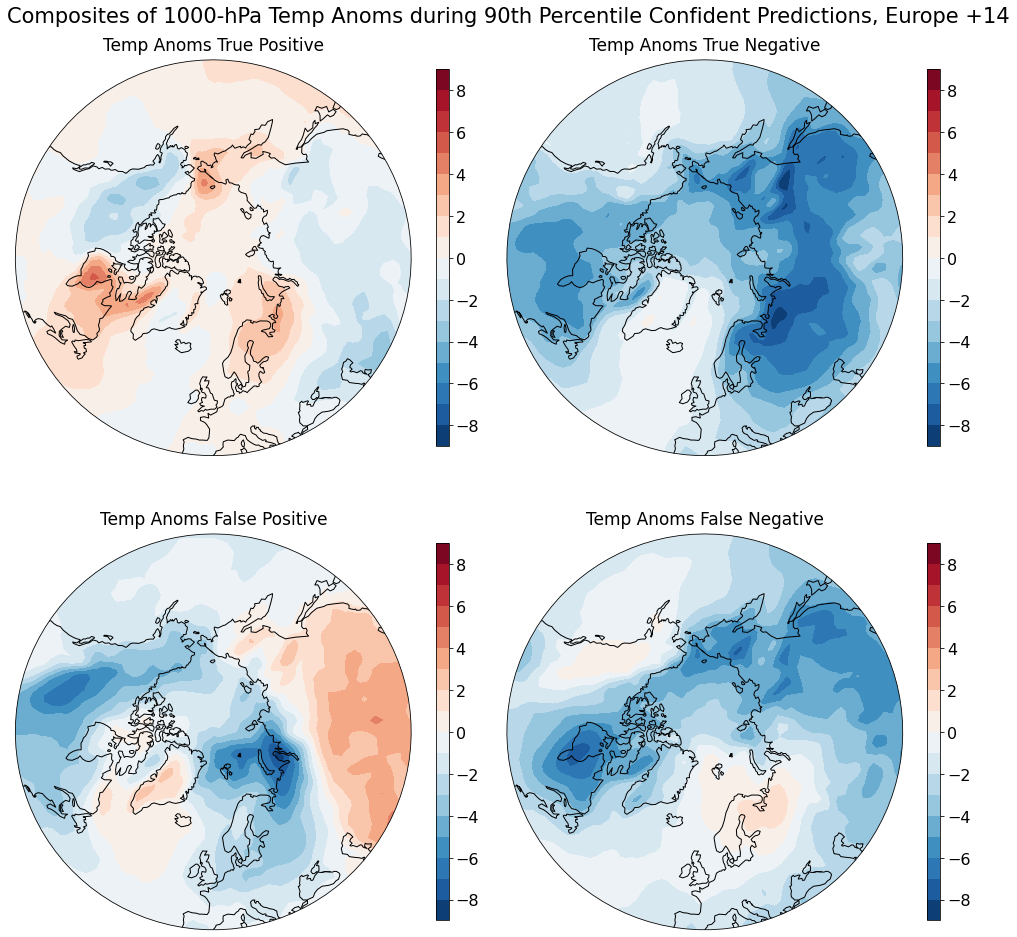

In [11]:
##Europe

##Box and Whisker Plot Europe +14
Tpos = BWcheckevent_label(eur_pos,eur_input,idx)
Tneg = BWcheckevent_label(eur_neg,eur_input,idx)
Fpos = BWcheckevent_label(eur_Fpos,eur_input,idx)
Fneg = BWcheckevent_label(eur_Fneg,eur_input,idx)

BWplot(Tpos,Tneg,Fpos,Fneg,eur_metrics_list," Europe +14","./images/eurBW_14.png")

##GPH Cross Section
#horizontal
GPH_cpos = CScheckevent_label(eur_pos,GPH,idx)
GPH_cneg = CScheckevent_label(eur_neg,GPH,idx)
GPH_Fpos = CScheckevent_label(eur_Fpos,GPH,idx)
GPH_Fneg = CScheckevent_label(eur_Fneg,GPH,idx)
GPHA_cpos = CScheckevent_label(eur_pos,GPHA,idx)
GPHA_cneg = CScheckevent_label(eur_neg,GPHA,idx)
GPHA_Fpos = CScheckevent_label(eur_Fpos,GPHA,idx)
GPHA_Fneg = CScheckevent_label(eur_Fneg,GPHA,idx)

GPH_horzCS(GPH_cpos,GPH_cneg,GPH_Fpos,GPH_Fneg,GPHA_cpos,GPHA_cneg,GPHA_Fpos,GPHA_Fneg,
               -1000,1000,100," Europe +14", lat, lon,"./images/eurGPHhorz_14.png")

#vertical
vert_GPH_cpos = CScheckevent_label(eur_pos,vert_GPH,idx)
vert_GPH_cneg = CScheckevent_label(eur_neg,vert_GPH,idx)
vert_GPH_Fpos = CScheckevent_label(eur_Fpos,vert_GPH,idx)
vert_GPH_Fneg = CScheckevent_label(eur_Fneg,vert_GPH,idx)

GPH_vertCS(vert_GPH_cpos,vert_GPH_cneg,vert_GPH_Fpos,vert_GPH_Fneg,
               -200,200,25," Europe +14", lev, lon,"./images/eurGPHvert_14.png")

##Temp Cross Section
TEMP_cpos = CScheckevent_label(eur_pos,TEMP,idx)
TEMP_cneg = CScheckevent_label(eur_neg,TEMP,idx)
TEMP_Fpos = CScheckevent_label(eur_Fpos,TEMP,idx)
TEMP_Fneg = CScheckevent_label(eur_Fneg,TEMP,idx)

Temp_horzCS(TEMP_cpos,TEMP_cneg,TEMP_Fpos,TEMP_Fneg, ", Europe +14", lat, lon, 
            "./images/eurTEMPhorz_14.png", -9,9,1)            

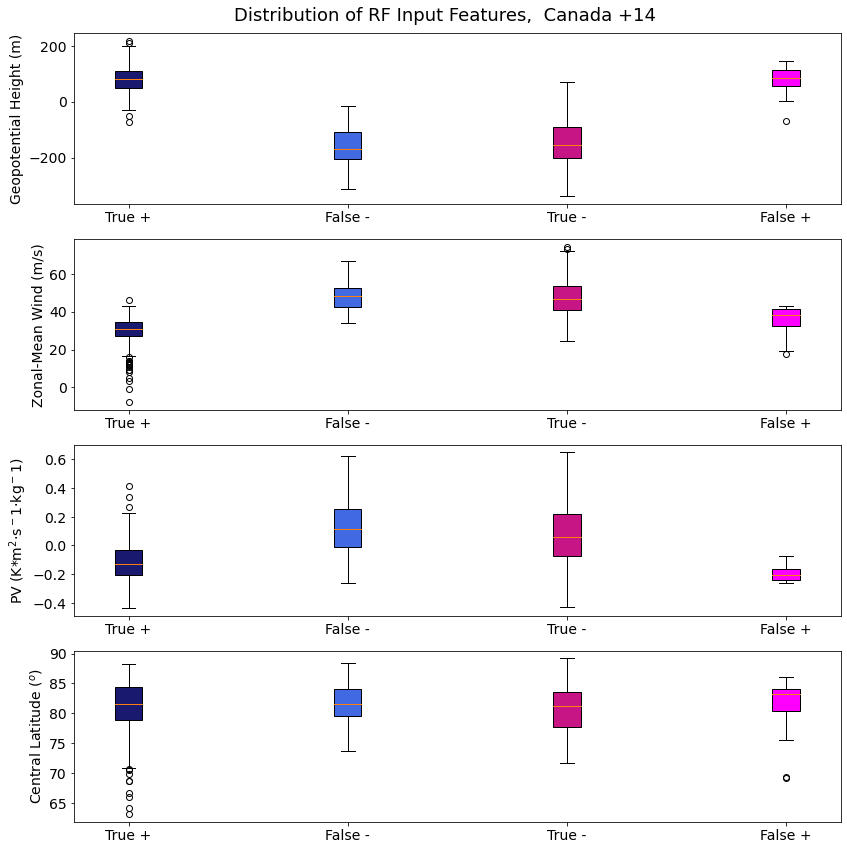

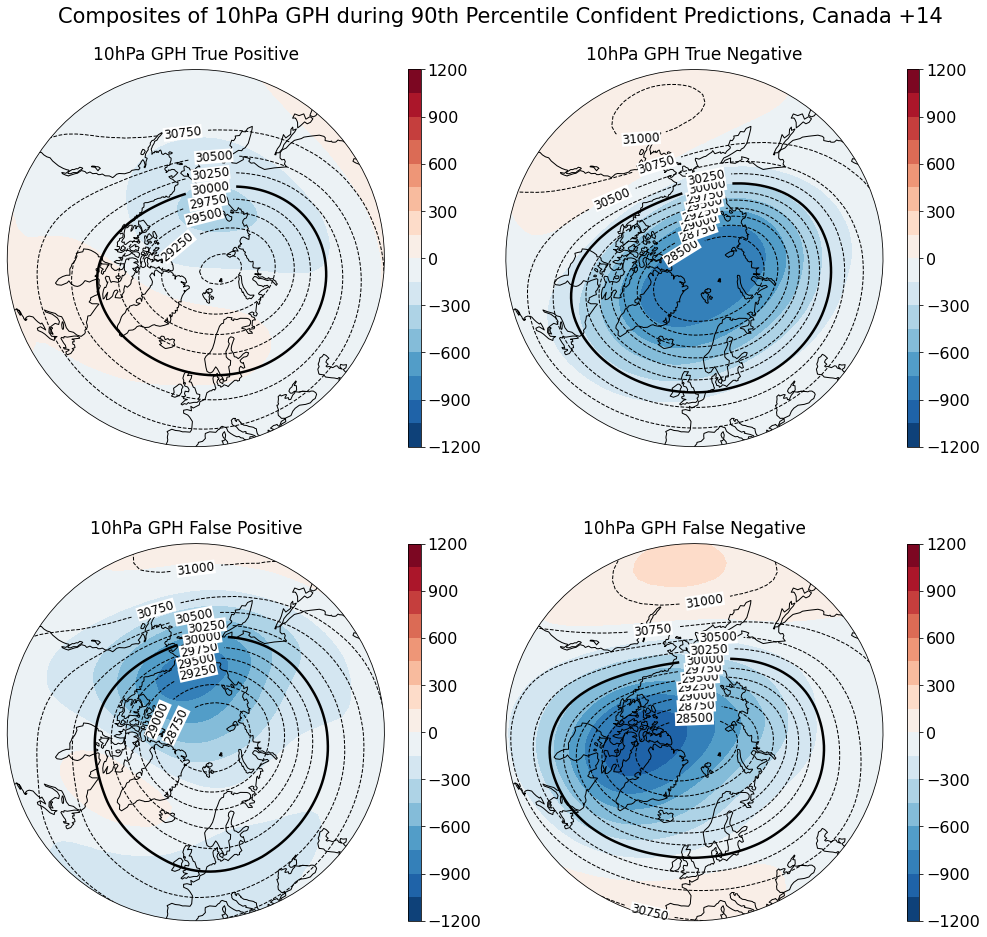

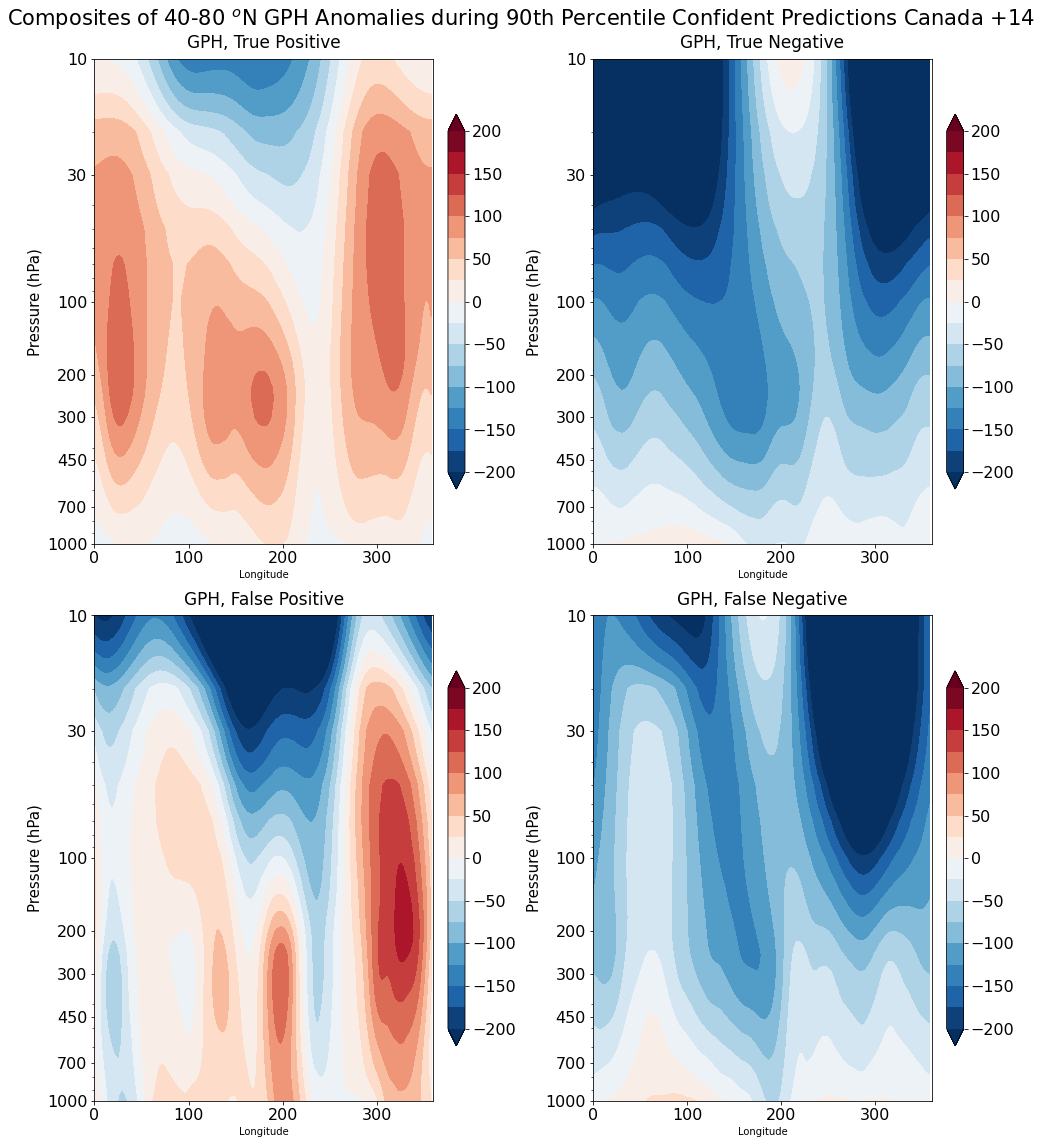

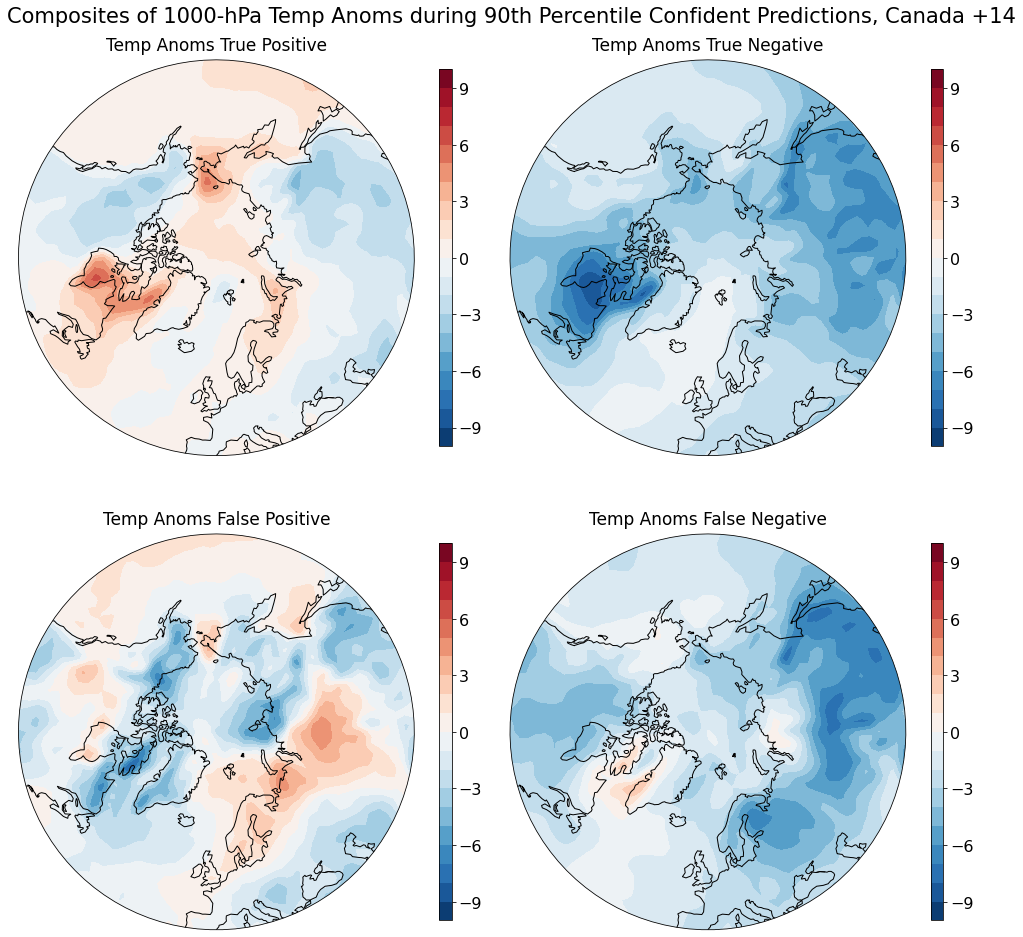

In [12]:
##Canada

##Box and Whisker Plot Canada +14
Tpos = BWcheckevent_label(can_pos,canada_input,idx)
Tneg = BWcheckevent_label(can_neg,canada_input,idx)
Fpos = BWcheckevent_label(can_Fpos,canada_input,idx)
Fneg = BWcheckevent_label(can_Fneg,canada_input,idx)

BWplot(Tpos,Tneg,Fpos,Fneg,canada_metrics_list," Canada +14","./images/canBW_14.png")

##GPH Cross Section
#horizontal
GPH_cpos = CScheckevent_label(can_pos,GPH,idx)
GPH_cneg = CScheckevent_label(can_neg,GPH,idx)
GPH_Fpos = CScheckevent_label(can_Fpos,GPH,idx)
GPH_Fneg = CScheckevent_label(can_Fneg,GPH,idx)
GPHA_cpos = CScheckevent_label(can_pos,GPHA,idx)
GPHA_cneg = CScheckevent_label(can_neg,GPHA,idx)
GPHA_Fpos = CScheckevent_label(can_Fpos,GPHA,idx)
GPHA_Fneg = CScheckevent_label(can_Fneg,GPHA,idx)

GPH_horzCS(GPH_cpos,GPH_cneg,GPH_Fpos,GPH_Fneg,GPHA_cpos,GPHA_cneg,GPHA_Fpos,GPHA_Fneg,
               -1200,1200,150," Canada +14", lat, lon,"./images/canGPHhorz_14.png")

#vertical
vert_GPH_cpos = CScheckevent_label(can_pos,vert_GPH,idx)
vert_GPH_cneg = CScheckevent_label(can_neg,vert_GPH,idx)
vert_GPH_Fpos = CScheckevent_label(can_Fpos,vert_GPH,idx)
vert_GPH_Fneg = CScheckevent_label(can_Fneg,vert_GPH,idx)

GPH_vertCS(vert_GPH_cpos,vert_GPH_cneg,vert_GPH_Fpos,vert_GPH_Fneg,
               -200,200,25," Canada +14", lev, lon,"./images/canGPHvert_14.png")

##Temp Cross Section
TEMP_cpos = CScheckevent_label(can_pos,TEMP,idx)
TEMP_cneg = CScheckevent_label(can_neg,TEMP,idx)
TEMP_Fpos = CScheckevent_label(can_Fpos,TEMP,idx)
TEMP_Fneg = CScheckevent_label(can_Fneg,TEMP,idx)

Temp_horzCS(TEMP_cpos,TEMP_cneg,TEMP_Fpos,TEMP_Fneg, ", Canada +14", lat, lon, 
            "./images/canTEMPhorz_14.png", -10,10,1)           

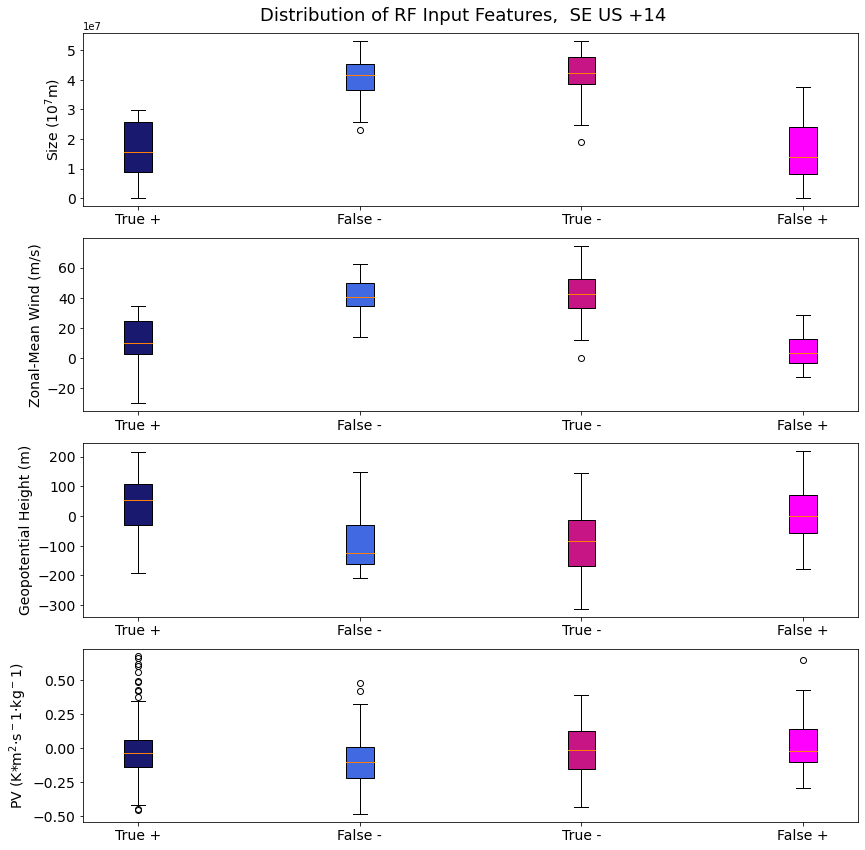

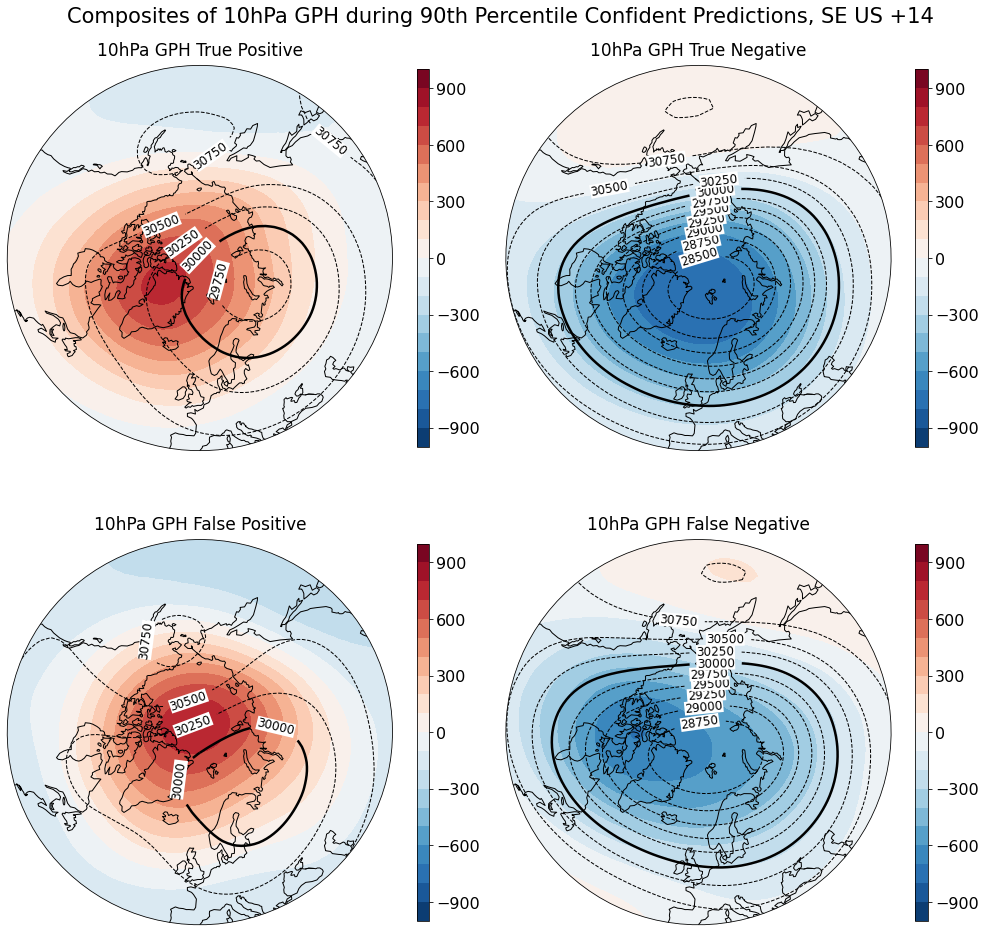

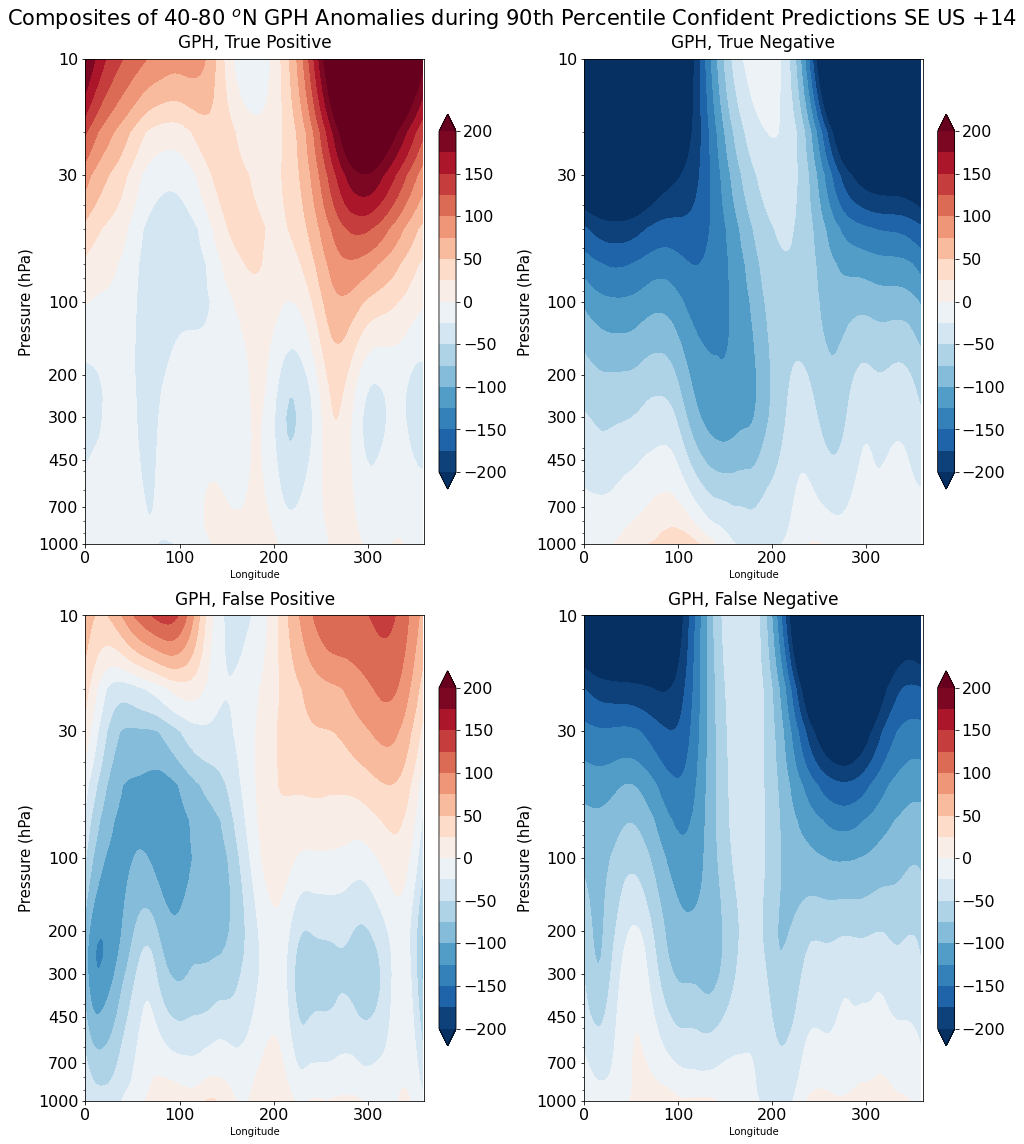

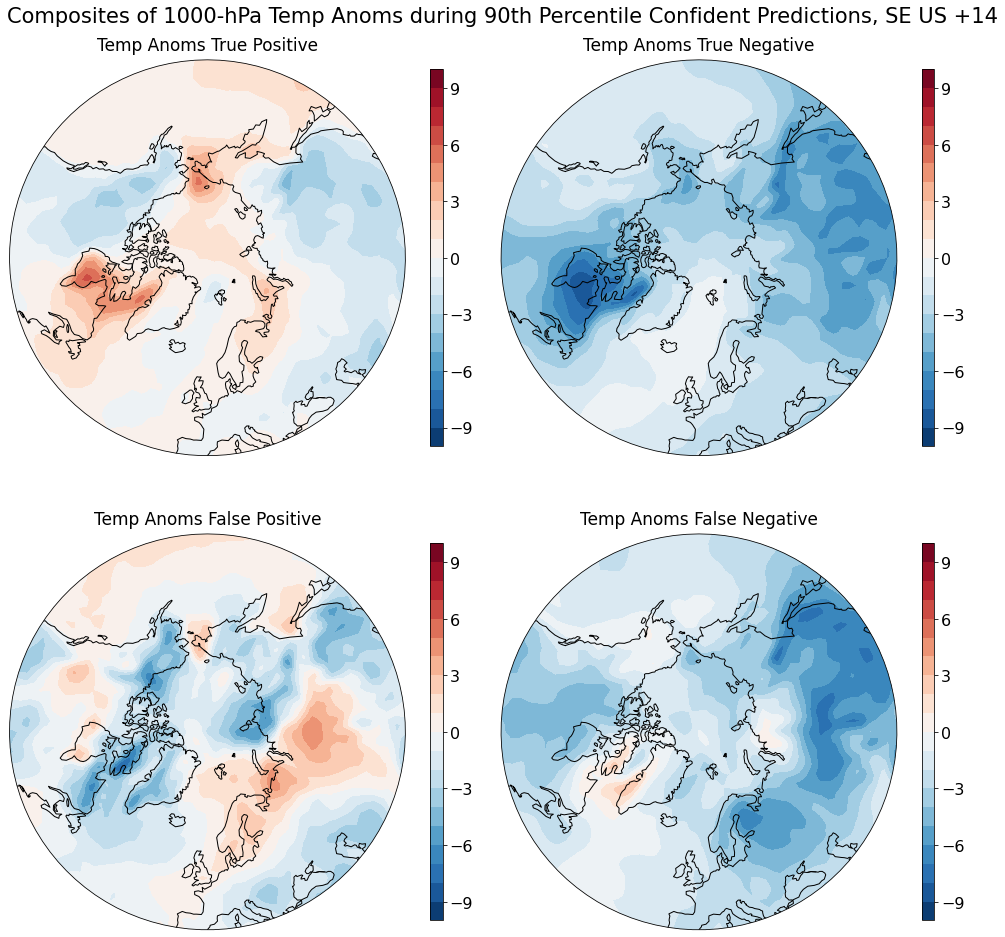

In [13]:
##SE US

##Box and Whisker Plot Canada +14
Tpos = BWcheckevent_label(seu_pos,seus_input,idx)
Tneg = BWcheckevent_label(seu_neg,seus_input,idx)
Fpos = BWcheckevent_label(seu_Fpos,seus_input,idx)
Fneg = BWcheckevent_label(seu_Fneg,seus_input,idx)

BWplot(Tpos,Tneg,Fpos,Fneg,seus_metrics_list," SE US +14","./images/seuBW_14.png")

##GPH Cross Section
#horizontal
GPH_cpos = CScheckevent_label(seu_pos,GPH,idx)
GPH_cneg = CScheckevent_label(seu_neg,GPH,idx)
GPH_Fpos = CScheckevent_label(seu_Fpos,GPH,idx)
GPH_Fneg = CScheckevent_label(seu_Fneg,GPH,idx)
GPHA_cpos = CScheckevent_label(seu_pos,GPHA,idx)
GPHA_cneg = CScheckevent_label(seu_neg,GPHA,idx)
GPHA_Fpos = CScheckevent_label(seu_Fpos,GPHA,idx)
GPHA_Fneg = CScheckevent_label(seu_Fneg,GPHA,idx)

GPH_horzCS(GPH_cpos,GPH_cneg,GPH_Fpos,GPH_Fneg,GPHA_cpos,GPHA_cneg,GPHA_Fpos,GPHA_Fneg,
               -1000,1000,100," SE US +14", lat, lon,"./images/seuGPHhorz_14.png")
#vertical
vert_GPH_cpos = CScheckevent_label(seu_pos,vert_GPH,idx)
vert_GPH_cneg = CScheckevent_label(seu_neg,vert_GPH,idx)
vert_GPH_Fpos = CScheckevent_label(seu_Fpos,vert_GPH,idx)
vert_GPH_Fneg = CScheckevent_label(seu_Fneg,vert_GPH,idx)

GPH_vertCS(vert_GPH_cpos,vert_GPH_cneg,vert_GPH_Fpos,vert_GPH_Fneg,
               -200,200,25," SE US +14", lev, lon,"./images/seuGPHvert_14.png")

##Temp Cross Section
TEMP_cpos = CScheckevent_label(can_pos,TEMP,idx)
TEMP_cneg = CScheckevent_label(can_neg,TEMP,idx)
TEMP_Fpos = CScheckevent_label(can_Fpos,TEMP,idx)
TEMP_Fneg = CScheckevent_label(can_Fneg,TEMP,idx)

Temp_horzCS(TEMP_cpos,TEMP_cneg,TEMP_Fpos,TEMP_Fneg, ", SE US +14", lat, lon, 
            "./images/seuTEMPhorz_14.png", -10,10,1)           

## Temp Comparison Plots

In [14]:
print("Europe")
print("#######")
less, greater = date_place(eur_pos, idx)
less_percent = round(less/len(eur_pos)*100,2)
greater_percent = round(greater/len(eur_pos)*100,2)
print("True Positive: There are "+str(less_percent)+"% of events before January 10th and "+str(greater_percent)+"% of events after.")
print("____________________________________________________")

less, greater = date_place(eur_neg, idx)
less_percent = round(less/len(eur_neg)*100,2)
greater_percent = round(greater/len(eur_neg)*100,2)
print("True Negative: There are "+str(less_percent)+"% of events before January 10th and "+str(greater_percent)+"% of events after.")
print("____________________________________________________")

less, greater = date_place(eur_Fpos, idx)
less_percent = round(less/len(eur_Fpos)*100,2)
greater_percent = round(greater/len(eur_Fpos)*100,2)
print("False Positive: There are "+str(less_percent)+"% of events before January 10th and "+str(greater_percent)+"% of events after.")
print("____________________________________________________")

less, greater = date_place(eur_Fneg, idx)
less_percent = round(less/len(eur_Fneg)*100,2)
greater_percent = round(greater/len(eur_Fneg)*100,2)
print("False Negative: There are "+str(less_percent)+"% of events before January 10th and "+str(greater_percent)+"% of events after.")
print("____________________________________________________")

print("Canada")
print("#######")
less, greater = date_place(can_pos, idx)
less_percent = round(less/len(can_pos)*100,2)
greater_percent = round(greater/len(can_pos)*100,2)
print("True Positive: There are "+str(less_percent)+"% of events before January 10th and "+str(greater_percent)+"% of events after.")
print("____________________________________________________")

less, greater = date_place(can_neg, idx)
less_percent = round(less/len(can_neg)*100,2)
greater_percent = round(greater/len(can_neg)*100,2)
print("True Negative: There are "+str(less_percent)+"% of events before January 10th and "+str(greater_percent)+"% of events after.")
print("____________________________________________________")

less, greater = date_place(can_Fpos, idx)
less_percent = round(less/len(can_Fpos)*100,2)
greater_percent = round(greater/len(can_Fpos)*100,2)
print("False Positive: There are "+str(less_percent)+"% of events before January 10th and "+str(greater_percent)+"% of events after.")
print("____________________________________________________")

less, greater = date_place(can_Fneg, idx)
less_percent = round(less/len(can_Fneg)*100,2)
greater_percent = round(greater/len(can_Fneg)*100,2)
print("False Negative: There are "+str(less_percent)+"% of events before January 10th and "+str(greater_percent)+"% of events after.")
print("____________________________________________________")

print("SE US")
print("#######")
less, greater = date_place(seu_pos, idx)
less_percent = round(less/len(seu_pos)*100,2)
greater_percent = round(greater/len(seu_pos)*100,2)
print("True Positive: There are "+str(less_percent)+"% of events before January 10th and "+str(greater_percent)+"% of events after.")
print("____________________________________________________")

less, greater = date_place(seu_neg, idx)
less_percent = round(less/len(seu_neg)*100,2)
greater_percent = round(greater/len(seu_neg)*100,2)
print("True Negative: There are "+str(less_percent)+"% of events before January 10th and "+str(greater_percent)+"% of events after.")
print("____________________________________________________")

less, greater = date_place(seu_Fpos, idx)
less_percent = round(less/len(seu_Fpos)*100,2)
greater_percent = round(greater/len(seu_Fpos)*100,2)
print("False Positive: There are "+str(less_percent)+"% of events before January 10th and "+str(greater_percent)+"% of events after.")
print("____________________________________________________")

less, greater = date_place(seu_Fneg, idx)
less_percent = round(less/len(seu_Fneg)*100,2)
greater_percent = round(greater/len(seu_Fneg)*100,2)
print("False Negative: There are "+str(less_percent)+"% of events before January 10th and "+str(greater_percent)+"% of events after.")
print("____________________________________________________")

Europe
#######
True Positive: There are 82.52% of events before January 10th and 17.48% of events after.
____________________________________________________
True Negative: There are 50.32% of events before January 10th and 49.68% of events after.
____________________________________________________
False Positive: There are 26.9% of events before January 10th and 73.1% of events after.
____________________________________________________
False Negative: There are 29.22% of events before January 10th and 70.78% of events after.
____________________________________________________
Canada
#######
True Positive: There are 98.52% of events before January 10th and 1.48% of events after.
____________________________________________________
True Negative: There are 29.23% of events before January 10th and 70.77% of events after.
____________________________________________________
False Positive: There are 100.0% of events before January 10th and 0.0% of events after.
________________________